In [61]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import os, time
import yfinance as yf


In [62]:
# Get BTC-USD data
btc = yf.download('BTC-USD', start='2018-01-01', end=datetime.now())
btc_df = pd.DataFrame(btc)

if isinstance(btc_df.columns, pd.MultiIndex):
    btc_df.columns = btc_df.columns.map(lambda col: col[0])
    btc_df['Date'] = pd.to_datetime(btc_df.index)
btc_df.set_index(btc_df.index, inplace=True)
btc_df['Return'] = btc_df['Close'].pct_change()

print(f"Date range: {btc_df.index[0]} to {btc_df.index[-1]}")


C:\Users\Viet Long\AppData\Local\Temp\ipykernel_1580\2196222745.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download('BTC-USD', start='2018-01-01', end=datetime.now())
[*********************100%***********************]  1 of 1 completed

Date range: 2018-01-01 00:00:00 to 2026-02-11 00:00:00


In [63]:
# historical simulation of T day return
def bootstrapped_cvar_T(returns_window, T, m, a):
    """
    returns_window: 1D array of past returns (length w)
    T: days ahead horizon
    m: number of bootstrap simulations
    a: CVaR level (e.g., 0.05)
    """
    w = len(returns_window)
    if w == 0:
        return np.nan

    # draw m simulations; each sim is T samples with replacement
    sims = np.random.choice(returns_window, size=(m, T), replace=True)

    # aggregate to T-day return
    # if simple returns: (1+r1)(1+r2)... - 1
    Tday_returns = np.prod(1 + sims, axis=1) - 1

    # CVaR = mean of worst a-quantile
    var_threshold = np.quantile(Tday_returns, a)
    cvar = Tday_returns[Tday_returns <= var_threshold].mean()
    return cvar

def update_cvar_cache(
    data,
    returns_col="Return",
    cvar_col="CVaR_T",
    w=100,
    T=365,
    m=10000,
    a=0.05,
    cache_path="cvar_monitor_cache.csv",
    force_rebuild=False,
):
    """
    Daily monitor mode:
    - Reuse previously simulated CVaR values from cache
    - Simulate only missing/new dates
    - If historical returns changed significantly, recalculate from first changed date onward
    """
    df = data.copy()
    df = df.sort_index()
    if cvar_col not in df.columns:
        df[cvar_col] = np.nan

    # --- load cache ---
    cache_exists = False
    if not force_rebuild and os.path.exists(cache_path):
        try:
            cached = pd.read_csv(cache_path, parse_dates=["Date"]).set_index("Date")
            cache_exists = True
        except Exception:
            cached = pd.DataFrame(columns=[returns_col, cvar_col])
    else:
        cached = pd.DataFrame(columns=[returns_col, cvar_col])

    if cache_exists:
        # Only keep cached rows whose dates still exist in incoming data
        common_dates = cached.index.intersection(df.index)
        cached = cached.loc[common_dates]

        # Check for changed historical returns (tolerance for CSV float round-trip)
        if returns_col in cached.columns and len(common_dates) > 0:
            ret_new = df.loc[common_dates, returns_col].values
            ret_old = cached[returns_col].values

            # Both NaN → same; both finite → compare with tolerance; else → changed
            both_nan = np.isnan(ret_new) & np.isnan(ret_old)
            close = np.isclose(ret_new, ret_old, rtol=1e-12, atol=1e-15, equal_nan=True)
            same = both_nan | close
            changed_mask = ~same

            if np.any(changed_mask):
                first_idx = np.argmax(changed_mask)  # index of first True
                first_changed = common_dates[first_idx]
                cached.loc[first_changed:, cvar_col] = np.nan
                print(f"[CVaR cache] returns changed from {first_changed}, invalidating cache forward")

        # Copy cached CVaR into df for common dates
        if cvar_col in cached.columns:
            df.loc[common_dates, cvar_col] = cached[cvar_col].values

    # --- compute only missing CVaR values ---
    missing_mask = df[cvar_col].isna() & (df.index >= df.index[w]) if len(df) > w else df[cvar_col].isna()
    missing_dates = df.index[missing_mask]

    n_computed = 0
    t0 = time.time()
    for dt in missing_dates:
        i = df.index.get_loc(dt)
        if i < w:
            continue
        window = df[returns_col].iloc[i - w:i].dropna().values
        if len(window) < w:
            continue
        df.at[dt, cvar_col] = bootstrapped_cvar_T(window, T=T, m=m, a=a)
        n_computed += 1

    elapsed = time.time() - t0
    total_valid = df[cvar_col].notna().sum()
    print(f"[CVaR cache] {total_valid} cached values reused, {n_computed} new values computed in {elapsed:.1f}s")

    # --- persist cache ---
    cache_out = df[[returns_col, cvar_col]].copy()
    cache_out.index.name = "Date"
    cache_out.to_csv(cache_path)

    return df

In [64]:
# monitor mode (incremental): reuse historical CVaR and simulate only new date(s)
# best params: 100d lookback, 365d horizon, 10000 bootstraps, CVaR 0.05 level
btc_df = update_cvar_cache(
    btc_df,
    returns_col="Return",
    cvar_col="CVaR_T",
    w=100,
    T=365,
    m=10000,
    a=0.05,
    cache_path="cvar_monitor_cache.csv",  # saved next to notebook working directory
    force_rebuild=False,
)


[CVaR cache] returns changed from 2026-02-11 00:00:00, invalidating cache forward
[CVaR cache] 2863 cached values reused, 1 new values computed in 0.1s


In [65]:
'''
Main logic of the indicator: 
1. Calculate rolling CVaR_T, which indicates the expected loss in the next T=365 days with a confidence level of a=0.05. 
2. Calculate the 250d EMA of CVaR_T
3. Generate signal based on the difference between CVaR_T EMA (t+2) and CVaR_T EMA (t): 
   - If CVaR_T EMA (t+2) < CVaR_T EMA (t) then signal = -1 (red, sell)
   - If CVaR_T EMA (t+2) > CVaR_T EMA (t) then signal = 1 (green, buy)
   - Else signal = 0 (grey, hold)
4. Filter: minimum (30) days between signal switches to avoid spurious switches and respect rebalancing frequency

'''
# date range
start = "2019-01-01"
end = datetime.now()
df_plot = btc_df.loc[start:end]

# EMA: 250d
cvar_ema = df_plot["CVaR_T"].ewm(span=250, adjust=True).mean()

# logic variable
signal = 0

# if CVaR_T EMA (t+1) < CVaR_T EMA (t) then signal = -1
# elif CVaR_T EMA (t+1) > CVaR_T EMA (t) then signal = 1
# else signal = 0

# delta is the difference between CVaR_T EMA (t+1) and CVaR_T EMA (t), diff of 2 days for more persistence
delta = cvar_ema.diff(2)
D = 30  # minimum days between signal switches to avoid spurious switches

raw_signal = pd.Series(
    np.where(delta < 0, 0, np.where(delta > 0, 1, 0)),
    index=cvar_ema.index
)

signal = raw_signal.copy()
last_switch_date = signal.index[0]
current = signal.iloc[0]

for i in range(1, len(signal)):
    desired = raw_signal.iloc[i]
    if desired == current:
        signal.iloc[i] = current
        continue

    # check months since last switch
    days_elapsed = (signal.index[i].to_period("D") - last_switch_date.to_period("D")).n
    if days_elapsed >= D:
        current = desired
        last_switch_date = signal.index[i]
    signal.iloc[i] = current

sig = signal.reindex(df_plot.index).fillna(0)

pos = sig.shift(1).fillna(0)  # use prior day's signal to avoid look-ahead bias
strat_ret = pos * df_plot["Return"]

cum = (1 + strat_ret).cumprod() - 1

#strat max drawdown
equity = 1 + cum
bnh_cum = (1 + df_plot["Return"]).cumprod()
print("CVaR strategy cumulative return: ", equity.iloc[-1])
print("BTC cumulative return: ", bnh_cum.iloc[-1])

CVaR strategy cumulative return:  84.17562486546286
BTC cumulative return:  18.047081620662517


In [66]:
# current signal and last switch
current_signal = signal.iloc[-1]
if pd.isna(current_signal):
    current_label = "unknown"
else:
    current_label = "green" if current_signal == 1 else "red"

signal_changes = signal.ne(signal.shift(1))
last_switch_date = signal.index[signal_changes].max()

print(f"Current signal: {current_label} ({current_signal})")
print(f"Last signal switch: {last_switch_date}")


Current signal: red (0)
Last signal switch: 2025-11-05 00:00:00


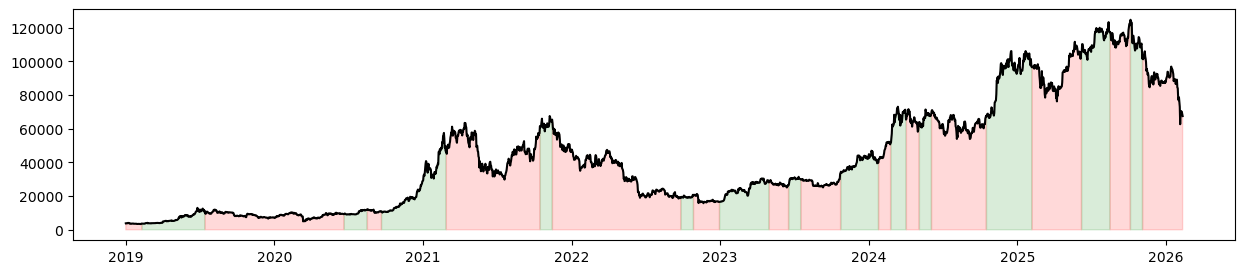

In [67]:
fig, ax1 = plt.subplots(figsize=(15, 3))
ax1.plot(df_plot.index, df_plot["Close"], color="black", label="BTC")


ax1.fill_between(
    df_plot.index, 0, df_plot["Close"],
    where=(sig == 1),
    color="green", alpha=0.15, label="signal = 1"
)

ax1.fill_between(
    df_plot.index, 0, df_plot["Close"],
    where=(sig == 0),
    color="red", alpha=0.15, label="signal = 0"
)

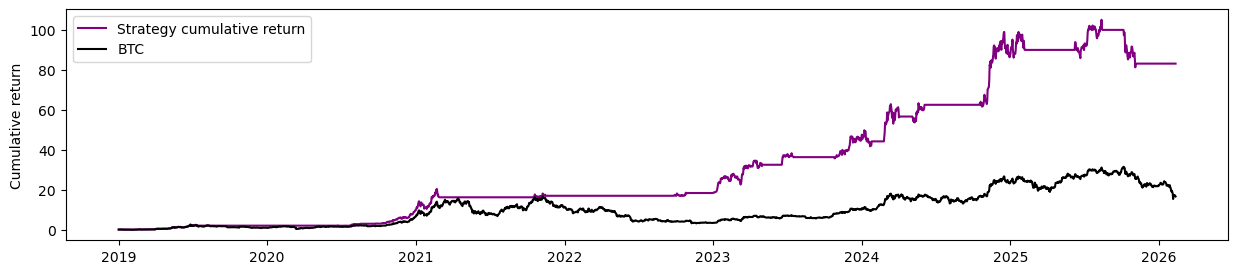

In [68]:
# sig: Series with values in {-1, 0, 1}
# ret: daily simple return series (e.g., df_plot["Return"])

plt.figure(figsize=(15, 3))
plt.plot(cum.index, cum, label="Strategy cumulative return", color="purple")
plt.plot(df_plot.index, df_plot["Close"]/df_plot["Close"].iloc[0]-1, label="BTC", color="black")
plt.ylabel("Cumulative return")
plt.legend()